In [1]:
# Enable this for some more verbose info.
debugging = False
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
K.clear_session()

Using TensorFlow backend.
C:\Users\FATTY\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\FATTY\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\FATTY\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\FATTY\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519

# Imports

In [2]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import random
import collections

# Root directory of the project
ROOT_DIR = os.path.abspath("C:/Users/FATTY/MaskRCNN/Training")
ROOT_IMAGE_DIR = os.path.abspath("images/")

# Path to the dataset (note this is a shared images directory)
dataset_path = os.path.join(ROOT_IMAGE_DIR)

models_dir = os.path.join(ROOT_DIR,  "models/")

print("base dataset dir:", dataset_path)
print("base models dir:", models_dir)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log

# Path to trained weights file
COCO_WEIGHTS_PATH = None

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

base dataset dir: C:\Users\FATTY\MaskRCNN\Training\images
base models dir: C:\Users\FATTY\MaskRCNN\Training\models/


In [3]:
# for visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

%matplotlib inline

In [4]:
# For Config and Dataset 
sys.path.append(os.path.join(dataset_path, "Training/"))  # To find local version
import Training.det as det

In [5]:
# For debugging...

if debugging:
    # Load annotations
    print(dataset_path)
    annotations = json.load(open(os.path.join(dataset_path, "train/annotations.json")))
    annotations = list(annotations.values())  # don't need the dict keys

    # The VIA tool saves images in the JSON even if they don't have any
    # annotations. Skip unannotated images.
    annotations = [a for a in annotations if a['regions']]

    for a in annotations:
        print(a['filename'])

# Configuration

In [6]:
# Create an object to hold configuration
config = det.DetConfig('bottle', ['bottle'])

# Load dataset

In [7]:
# Load dataset
dataset, _ = det.create_datasets(dataset_path+"/train",  config)
                                 

# Must call before using the dataset, amount other things,
# this maps the sources to the class ids.
dataset.prepare() 

# Print a summary of the dataset and classes
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Counter({'bottle': 19})
Counter({'bottle': 4})
Adding class   1:bottle
Adding class   1:bottle
Image Count: 16
Class Count: 2
  0. BG                                                
  1. bottle                                            


# Display Samples

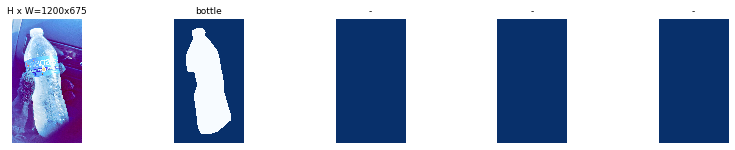

(1200, 675, 1)

In [8]:
image_id = 0
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
mask.shape

In [9]:
if debugging:
    for image_id in dataset.image_ids:
        print("image_id: ", image_id)
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
        mask.shape

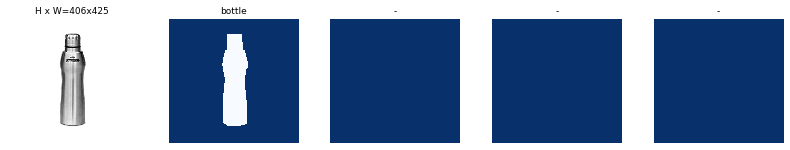

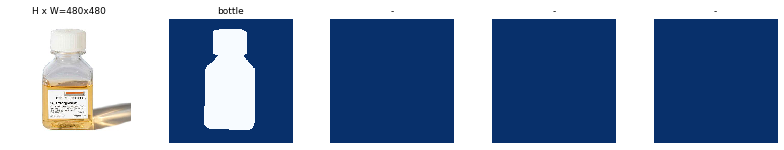

In [10]:
from mrcnn import visualize
from mrcnn.visualize import display_images

# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 2)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)


# Bounding Boxes

image_id  15 C:\Users\FATTY\MaskRCNN\Training\images/train\ActiOn_18.jpg
image                    shape: (300, 236, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (300, 236, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   35.00000  max:  260.00000  int32


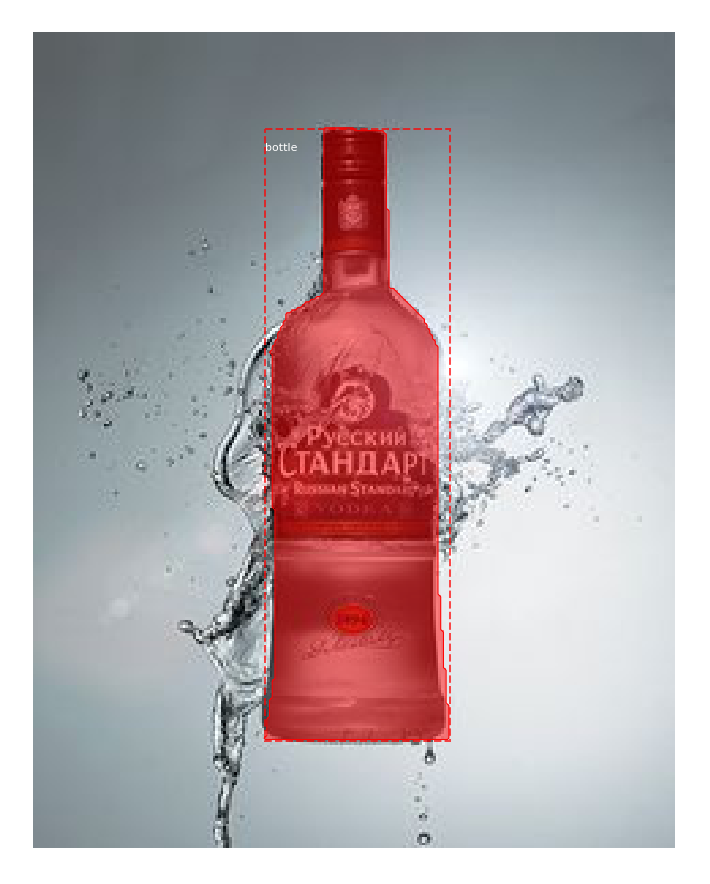

In [11]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)

image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

type(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Prepare images 

image_id:  3 C:\Users\FATTY\MaskRCNN\Training\images/train\ActiOn_66.jpg
Original shape:  (400, 300, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   33.00000  max:  930.00000  int32


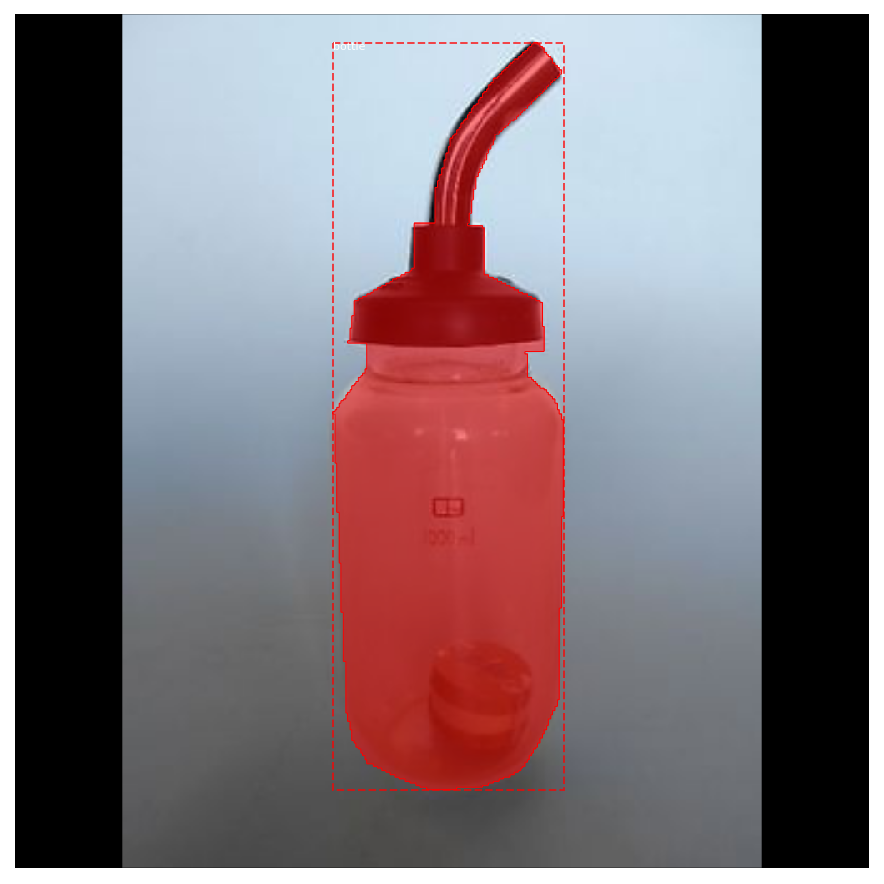

In [12]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Mini Masks

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   33.00000  max:  930.00000  int32
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


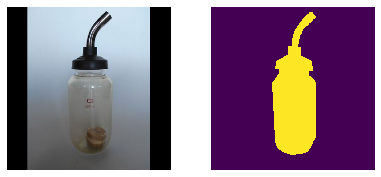

In [13]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

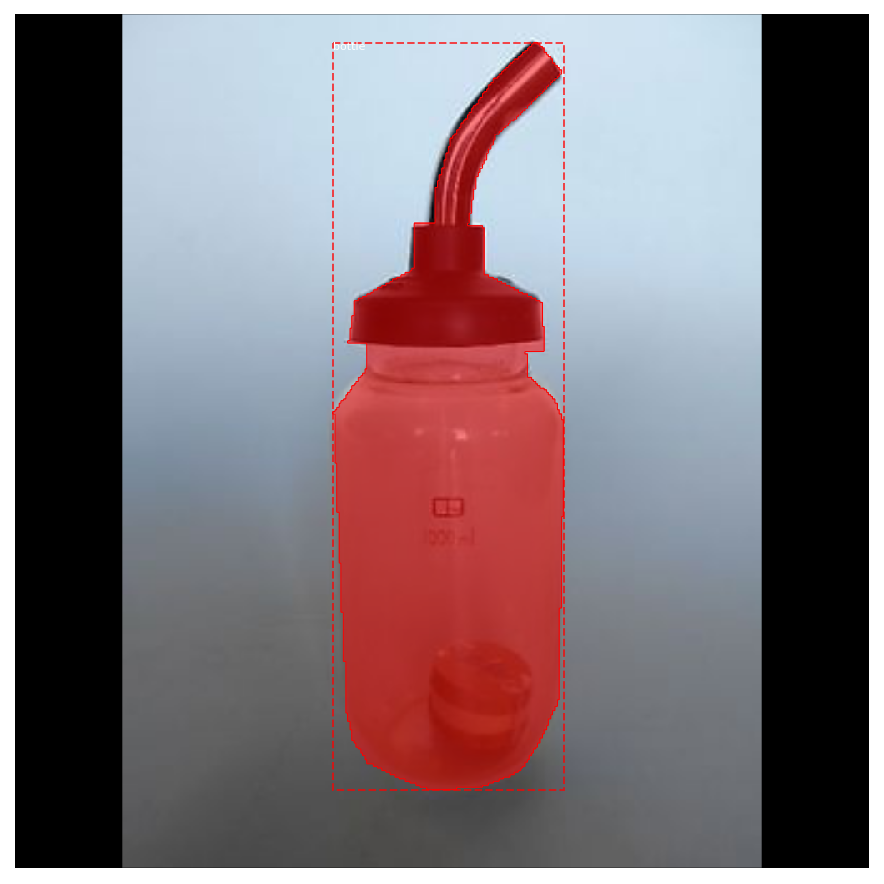

In [14]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Agumentations

In [15]:
# The imgaug library is pretty flexible and make different types of augmentation possible. 
# The deterministic setting is used because any spatial changes to the image must also be 
# done to the mask. There are also some augmentors that are unsafe to apply. From the mrcnn
# library: 
# Augmentors that are safe to apply to masks: 
# ["Sequential", "SomeOf", "OneOf", "Sometimes","Fliplr", 
# "Flipud", "CropAndPad", "Affine", "PiecewiseAffine"]
# Affine, has settings that are unsafe, so always
# test your augmentation on masks

import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(1)

# http://imgaug.readthedocs.io/en/latest/source/augmenters.html#sequential
seq_of_aug = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)), # random crops
    
    # horizontally flip 50% of the images
    iaa.Fliplr(0.5), 

    # Gaussian blur to 50% of the images
    # with random sigma between 0 and 0.5.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    
    # Apply affine transformations to each image.
    # Scale/zoom them from 90% 5o 110%
    # Translate/move them, rotate them
    # Shear them slightly -2 to 2 degrees.
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-5, 5),
        shear=(-2, 2)
    )
], random_order=True) # apply augmenters in random order

C:\Users\FATTY\Anaconda\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


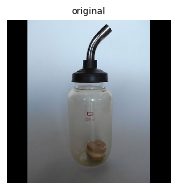

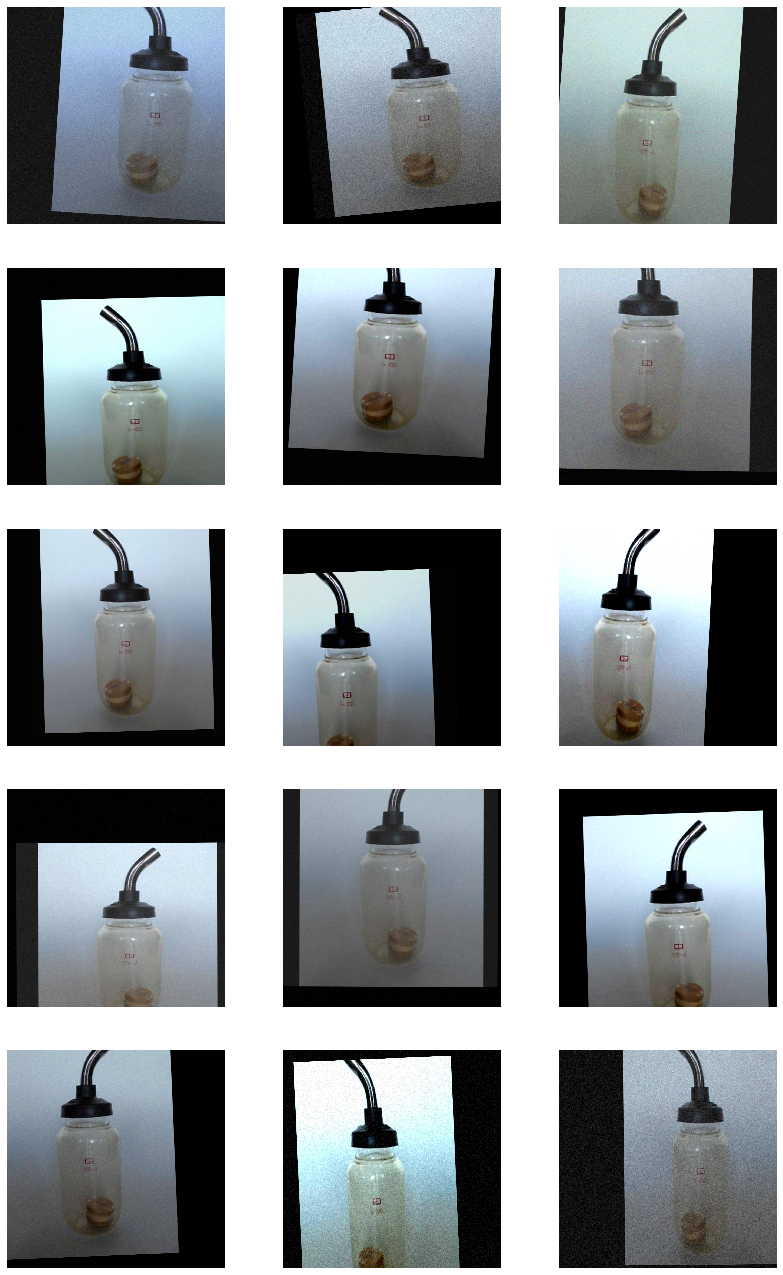

In [16]:
# Some example augmentations using the seq defined above.
display_images( [image], titles=['original'])

image_list = []
for i in range(15):
    image_aug = seq_of_aug.augment_image(image)
    image_list.append( image_aug)
    
display_images( image_list, cols=3)

mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


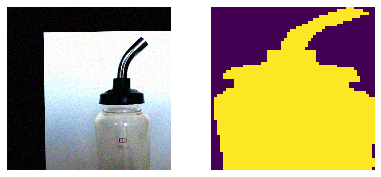

In [17]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augmentation=seq_of_aug, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

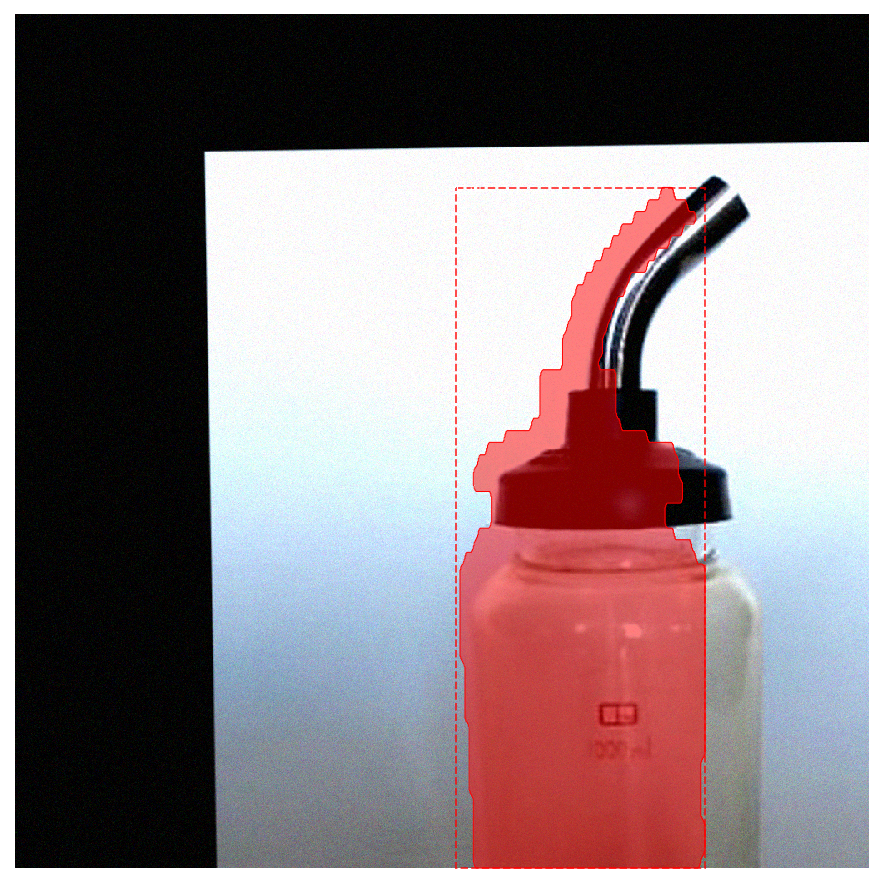

In [18]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Anchor Boxes

In [19]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


# Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


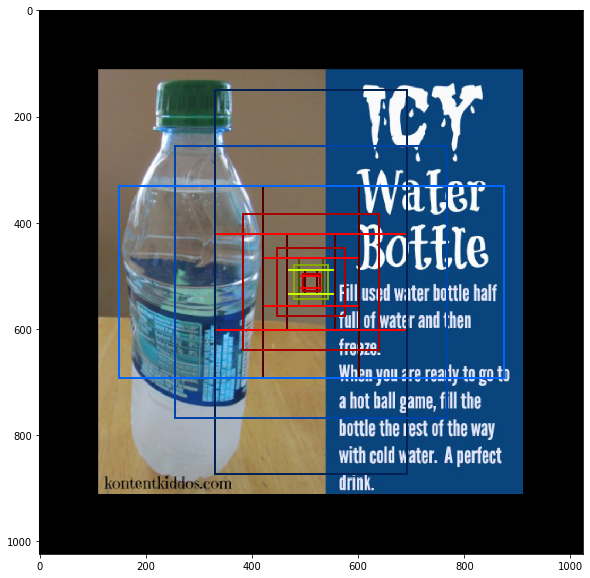

In [20]:
## Visualize anchors of one cell at the center of the feature map of a specific level



# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

# Data Generator

In [21]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True,
    augmentation=seq_of_aug
    )

In [22]:
if debugging:
    # Run the generator through a lot of images
    for i in range(2):
        print(i)
        _, _ = next(g)

In [23]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 200, 4)           min:    0.00000  max: 1023.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 200, 2, 4)        min:   -3.44203  max:    3.37017  float32
mrcnn_mask               shape: (4, 200, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  924.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -2.41687  max:    2.23733  float64
image_id:  0 C:\Users\FATTY\MaskRCNN\Training\images/train\ActiOn_19.jpg


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (4, 4)                min:    0.00000  max:  744.00006  float32
Positive anchors: 4
Negative anchors: 252
Neutral anchors: 261632
BG                     : 157
bottle                 : 43


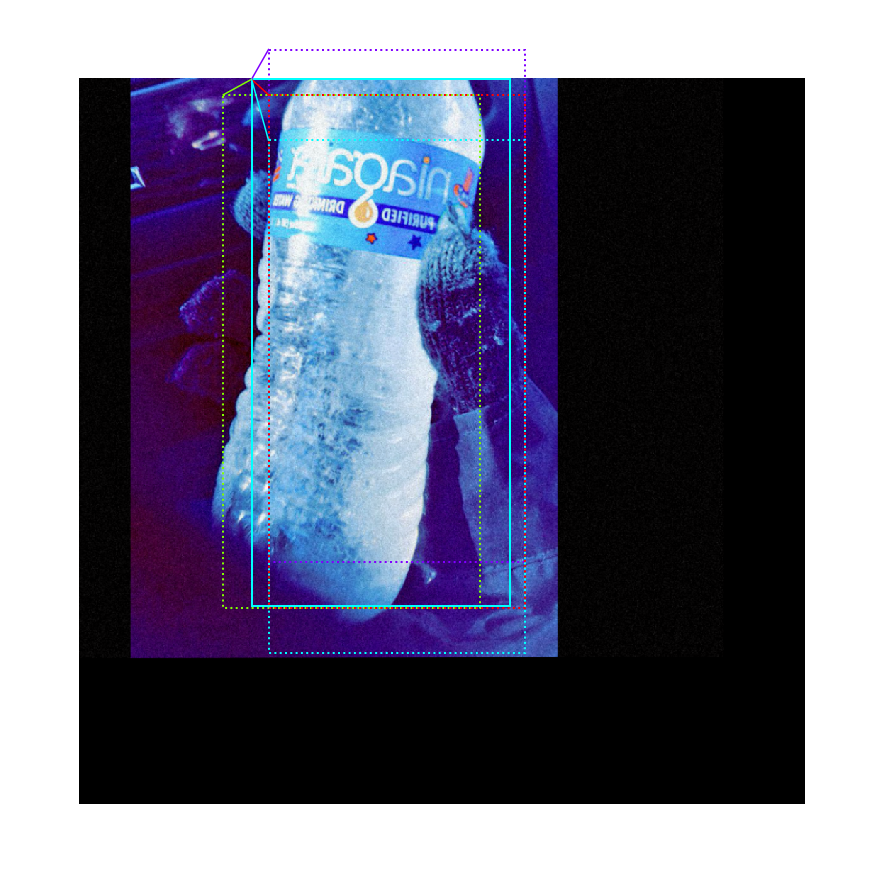

In [24]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

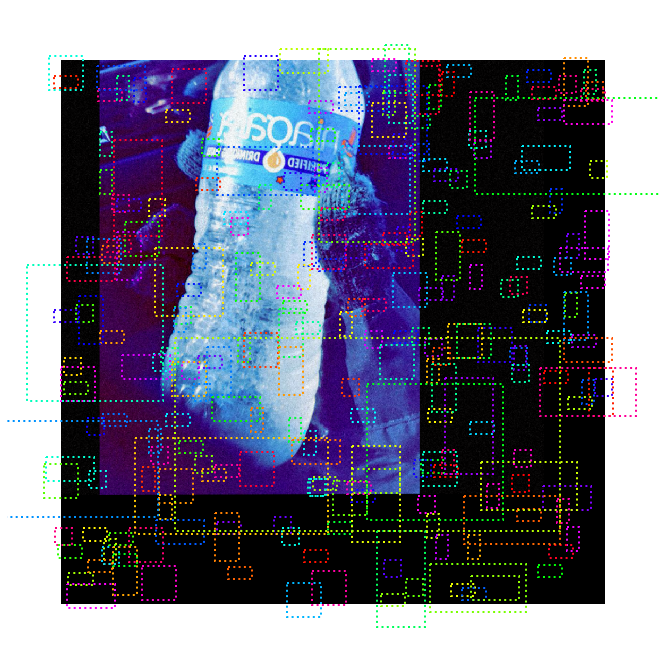

In [25]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

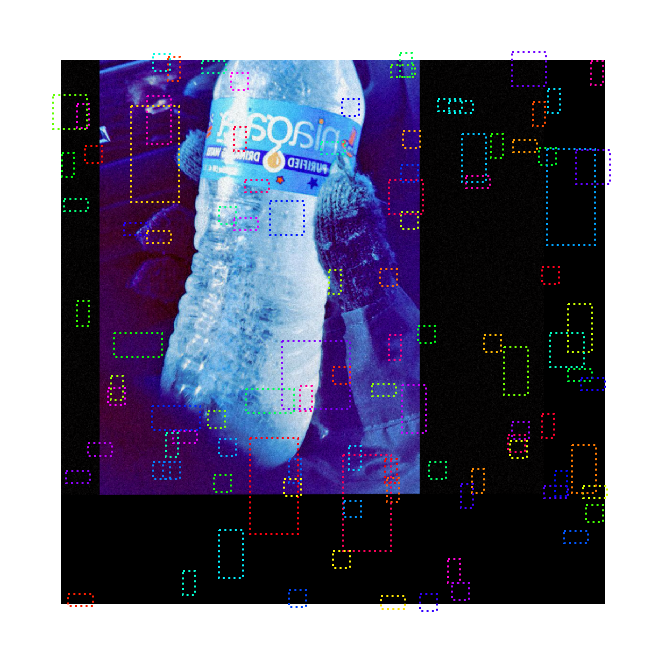

In [26]:

# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

# Regions of Interest

Positive ROIs:  43
Negative ROIs:  157
Positive Ratio: 0.21
Unique ROIs: 200 out of 200


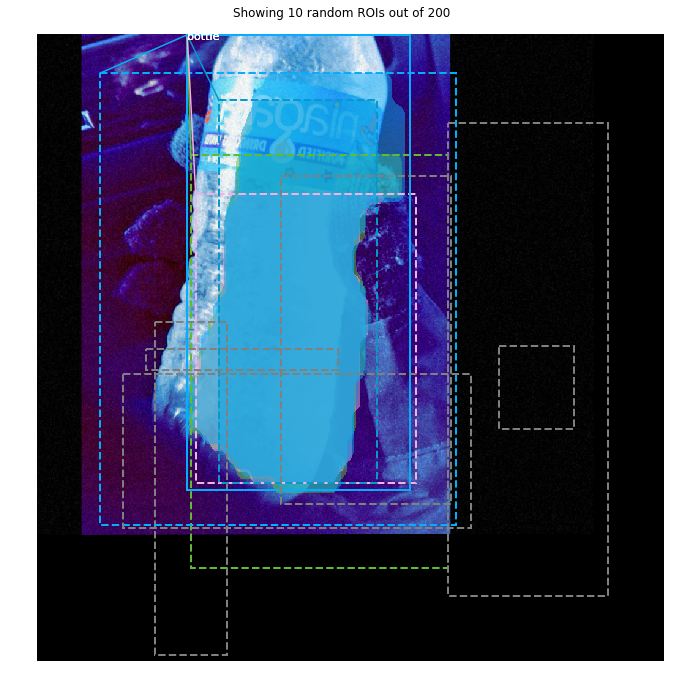

In [27]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

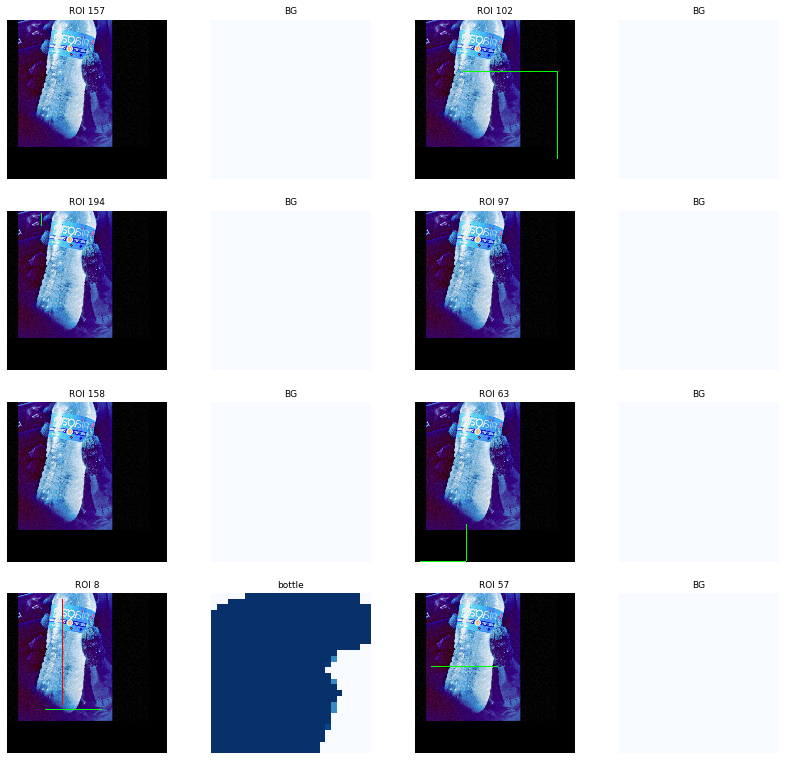

In [28]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [29]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33


# Train

In [30]:
print("dataset dir:", dataset_path)
print("models dir:", models_dir)

dataset dir: C:\Users\FATTY\MaskRCNN\Training\images
models dir: C:\Users\FATTY\MaskRCNN\Training\models/


In [31]:
# Setup configuration
config = det.DetConfig('bottle', ['bottle'])
config.display()


Configurations:
ACTIVATION                     relu
ALL_CLASS_NAMES                ['BG', 'bottle']
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['bottle']
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 

In [32]:
config.ACTIVATION = 'leakyrelu'
config.ACTIVATION

'leakyrelu'

In [33]:
# Create the model
model = modellib.MaskRCNN(mode='training', 
                          config=config,
                          model_dir=models_dir) 

model.keras_model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (No

In [51]:


def train(model, dataset_path, epochs=30):
    """Train the model."""
    
    # Create the train and val dataset.
    dataset_train, dataset_val = det.create_datasets(dataset_path+'/train', config)

    # Prepare them
    dataset_train.prepare()
    dataset_val.prepare()

    # Experiment with training options.
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    history = model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=epochs,
                layers='heads', 
                augmentation=seq_of_aug
                )
    
    return history         

In [52]:
history = train(model, dataset_path, 3)

Counter({'bottle': 18})
Counter({'bottle': 5})
Adding class   1:bottle
Adding class   1:bottle
Training network heads


TypeError: fit_generator() got multiple values for argument 'steps_per_epoch'

In [45]:
print(history.history.keys())

AttributeError: 'NoneType' object has no attribute 'history'

In [124]:
import math

def plot_history(history):
    
    fig = plt.figure(figsize=(16,10))
       
    n_history_loss = len(history.history)
    n_epochs = len(history.epoch)
    epoch = history.epoch
    
    # The loss is in pairs, one for train, one for val
    loss_stats = [ k for k in history.history.keys() if 'val_' not in k ]
    
    n_cols = 4
    n_rows = math.ceil(len(loss_stats) / n_cols) 
    
    for i, k in enumerate(loss_stats):
        val_k = 'val_'+k
        ax = plt.subplot( n_rows, n_cols, i+1)
        ax.plot(epoch, history.history[k], label=k)
        ax.plot(epoch, history.history[val_k], label=val_k)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title(str(i)+' - '+k)
        plt.legend(shadow=True, fancybox=True)
    
    fig.tight_layout()
    plt.show()

In [39]:
# Plot training stats for each of the networks.
plot_history(history)

AttributeError: 'NoneType' object has no attribute 'history'

<Figure size 1152x720 with 0 Axes>

In [41]:
class InferenceConfig(det.DetConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
#    NUM_CLASSES = 2 # For BG + Others
    
inf_config = InferenceConfig('bottle', ['bottle'])
inf_model = modellib.MaskRCNN(mode="inference", 
                              config=inf_config,
                              model_dir=models_dir)

inf_config.display()

# Find last trained weights
#weights_path = inf_model.find_last()[1]

# When testing use the latest, for demo use stable model
weights_path = os.path.join(models_dir, "mask_rcnn_bottle_0002.h5")
# weights_path = os.path.join(models_dir, "wolf20180516T0136_mask_rcnn_wolf_0075.h5")


print("Using latest weights: ", weights_path)

inf_model.load_weights(weights_path, by_name=True)


Configurations:
ACTIVATION                     relu
ALL_CLASS_NAMES                ['BG', 'bottle']
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['bottle']
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 

In [42]:
import glob

def detect_instance(class_names, image_test_dir):
    """
    class_names: list of class names of the dataset
    image_filenames: list of images to analyze
    """

    det_filenames = sorted(glob.glob(image_test_dir+'/*'))

    for f in det_filenames:
        print("Processing image {}".format(f))

        test_img = plt.imread(f)
        print(test_img.shape)

        plt.imshow(test_img)
        # visualize.display_images([test_img])

        # Included in the results from detect are the found:
        # class_ids,their scores and masks.
        results = inf_model.detect([test_img], verbose=1)[0]

        print("Objects detected: ", len(results['class_ids']))

        # Visualize results
        visualize.display_instances(test_img, 
                                    results['rois'], 
                                    results['masks'], 
                                    results['class_ids'], 
                                    class_names, 
                                    results['scores'])

        print(results['class_ids'])

In [43]:
import math

def detect_instances(class_names, image_test_dir):
    """
    class_names: list of class names of the dataset
    image_filenames: list of images to analyze
    """
        
    det_filenames = sorted(glob.glob(image_test_dir+'/*'))

    fig = plt.figure(figsize=(16,10))

    n_cols = 3
    n_rows = math.ceil(len(det_filenames) / n_cols) 
    
    
    for i, f in enumerate(det_filenames):
        
        print("Processing image {}".format(f))
        
        ax = plt.subplot( n_rows, n_cols, i+1)

        test_img = plt.imread(f)

        # Included in the results from detect are the found:
        # class_ids,their scores and masks.
        results = inf_model.detect([test_img], verbose=1)[0]

        print("Objects detected: ", len(results['class_ids']))

        # Visualize results
        visualize.display_instances(test_img, 
                                    results['rois'], 
                                    results['masks'], 
                                    results['class_ids'], 
                                    class_names, 
                                    results['scores'],
                                    ax=ax)

        print(results['class_ids'])

Processing image C:\Users\FATTY\MaskRCNN\Training\images\ActiOn_19.jpg
Processing 1 images
image                    shape: (1200, 675, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Objects detected:  3
[1 1 1]
Processing image C:\Users\FATTY\MaskRCNN\Training\images\ActiOn_25.jpg
Processing 1 images
image                    shape: (664, 498, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Objects detected:  1
[1]


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,2) and requested shape (2,2)

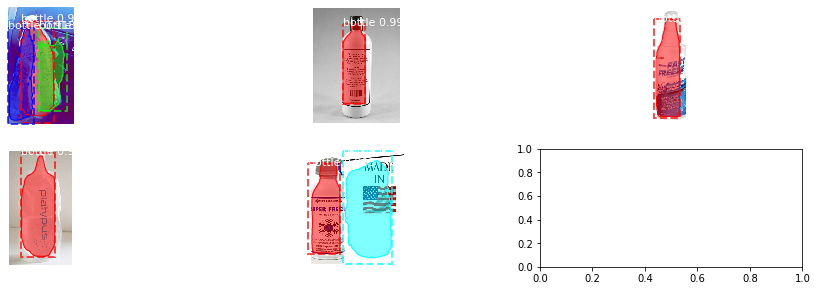

In [44]:
image_test_dir = os.path.join(ROOT_IMAGE_DIR)

if debugging:
    r = detect_instance(inf_config.ALL_CLASS_NAMES, image_test_dir)
else:
    r = detect_instances(inf_config.ALL_CLASS_NAMES, image_test_dir)

# Evaluate

In [47]:
, dataset_val = det.create_datasets(dataset_path, inf_config)
dataset_val.prepare()

NameError: name 'dataset_val' is not defined